<a href="https://colab.research.google.com/github/mirsaidl/tensorflow_implementations/blob/main/siamese_network_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


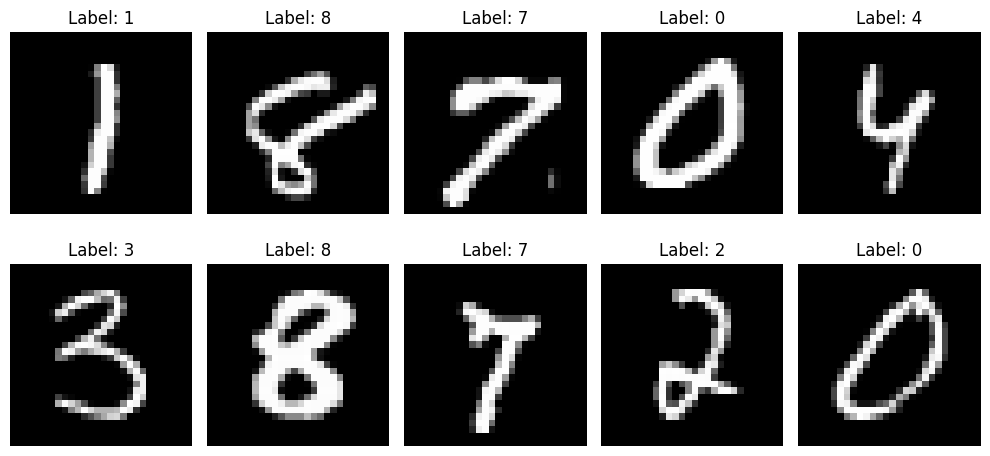

In [4]:
# Randomly select 10 indices
random_indices = np.random.randint(0, x_train.shape[0], size=10)

# Plot the images
plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
A = Input((28,28), name='input_A')
B = Input((28,28), name='input_B')

In [7]:
def get_cnn_block(depth):
  return Sequential([Conv2D(depth, 3, 1),
                     BatchNormalization(),
                     ReLU()])

In [8]:
DEPTH = 64
cnn =  Sequential([
    Reshape((28,28,1)),
    get_cnn_block(DEPTH*2),
    get_cnn_block(DEPTH*4),
    get_cnn_block(DEPTH*8),
    GlobalAveragePooling2D(),
    Dense(64, activation='relu')
])

In [9]:
fv_A = cnn(A)
fv_B = cnn(B)

concat = Concatenate()([fv_A, fv_B])
dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)
model = Model(inputs=[A,B], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_A (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 input_B (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 64)                   1513024   ['input_A[0][0]',             
                                                                     'input_B[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 128)                  0         ['sequential_3[0][0]',    

In [11]:
random_indices = np.random.choice(x_train.shape[0], 300, replace=False)

x_train_sample, y_train_sample = x_train[random_indices], y_train[random_indices]

x_train_sample.shape, y_train_sample.shape

((300, 28, 28), (300,))

In [12]:
len(x_train_sample) ** 2

90000

In [14]:
import itertools

def make_paired_dataset(X, y):
  X_pairs, y_pairs = [], []

  tuples = [(x1, y1) for x1, y1 in zip(X, y)]

  for t in itertools.product(tuples, tuples):
    pair_A, pair_B = t
    img_A, label_A = t[0]
    img_B, label_B = t[1]

    new_label = int(label_A == label_B)

    X_pairs.append([img_A, img_B])
    y_pairs.append(new_label)

  X_pairs = np.array(X_pairs)
  y_pairs = np.array(y_pairs)

  return X_pairs, y_pairs

In [16]:
make_paired_dataset(x_train_sample, y_train_sample)

(array([[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0

In [17]:
x_train_pairs, y_train_pairs = make_paired_dataset(x_train_sample, y_train_sample)

x_train_pairs.shape, y_train_pairs.shape

((90000, 2, 28, 28), (90000,))

In [18]:
random_indices = np.random.choice(x_test.shape[0], 150, replace=False)

x_test_sample, y_test_sample = x_test[random_indices], y_test[random_indices]

x_test_sample.shape, y_test_sample.shape

((150, 28, 28), (150,))

In [19]:
x_test_pairs, y_test_pairs = make_paired_dataset(x_test_sample, y_test_sample)

x_test_pairs.shape, y_test_pairs.shape

((22500, 2, 28, 28), (22500,))

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)

In [23]:
model.fit(x=[x_train_pairs[:, 0, :, :], x_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_data=([x_test_pairs[:, 0, :, :],
                            x_test_pairs[:, 1, :, :]],
                           y_test_pairs),
          epochs=10,
          batch_size=32,
          callbacks=[es])

Epoch 1/10
2813/2813 [==============================] - 137s 49ms/step - loss: 0.1231 - accuracy: 0.9464 - val_loss: 0.3096 - val_accuracy: 0.8810
Epoch 2/10
2813/2813 [==============================] - 138s 49ms/step - loss: 0.0327 - accuracy: 0.9888 - val_loss: 0.3093 - val_accuracy: 0.9213
Epoch 3/10
2813/2813 [==============================] - 138s 49ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.3056 - val_accuracy: 0.9352
Epoch 4/10
2813/2813 [==============================] - 139s 49ms/step - loss: 0.0094 - accuracy: 0.9969 - val_loss: 0.3665 - val_accuracy: 0.9351
Epoch 5/10
2813/2813 [==============================] - 139s 49ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.2569 - val_accuracy: 0.9460
Epoch 6/10
2813/2813 [==============================] - 139s 49ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.2698 - val_accuracy: 0.9458
Epoch 7/10
2813/2813 [==============================] - 139s 49ms/step - loss: 0.0065 - accuracy: 0.9982 - val_loss: 0

In [25]:
img_A, img_B = x_test[0], x_test[17]
label_A, label_B = y_test[0], y_test[17]

label_A, label_B

(7, 7)

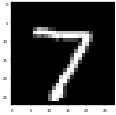

In [27]:
plt.figure(dpi=28)
plt.imshow(img_A, cmap='gray')
plt.show()

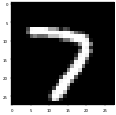

In [29]:
plt.figure(dpi=28)
plt.imshow(img_B, cmap='gray')
plt.show()

In [30]:
model.predict([img_A.reshape((1, 28, 28)),
               img_B.reshape((1, 28, 28))]) # 100% which is correct

1/1 [==============================] - 1s 1s/step


array([[1.]], dtype=float32)

In [34]:
# Let's compare different numbers
img_A, img_B = x_test[5], x_test[15]
label_A, label_B = y_test[5], y_test[15]

label_A, label_B

(1, 5)

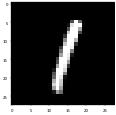

In [35]:
plt.figure(dpi=28)
plt.imshow(img_A, cmap='gray')
plt.show()

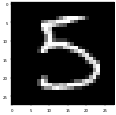

In [36]:
plt.figure(dpi=28)
plt.imshow(img_B, cmap='gray')
plt.show()

In [37]:
model.predict([img_A.reshape((1, 28, 28)),
               img_B.reshape((1, 28, 28))])
# As you can see probability is too small (0.000000000000013)

1/1 [==============================] - 0s 38ms/step


array([[1.3491789e-14]], dtype=float32)